In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cirq import Circuit, rx, CNOT, DensityMatrixSimulator, LineQubit, depolarize

from mitiq.zne import mitigate_executor
from mitiq.zne.inference import RichardsonFactory

SIMULATOR = DensityMatrixSimulator()

In [2]:
def variational_circuit(gamma: float) -> Circuit:
    """Returns a two-qubit circuit for a given variational parameter.

    Args:
        gamma: The variational parameter.

    Returns:
        The two-qubit circuit with a fixed gamma.
    """

    q0, q1 = LineQubit.range(2)

    return Circuit([rx(gamma)(q0), CNOT(q0, q1), rx(gamma)(q1), CNOT(q0, q1), rx(gamma)(q0)])

In [3]:
print(variational_circuit(gamma=np.pi))

0: ───Rx(π)───@───────────@───Rx(π)───
              │           │
1: ───────────X───Rx(π)───X───────────


In [4]:
# Observable to measure
z = np.diag([1, -1])
hamiltonian = np.kron(z, z)

def noiseless_executor(circ: Circuit) -> float:
    """Simulates the execution of a circuit without noise.

    Args:
        circ: The input circuit.

    Returns:
        The expectation value of the ZZ observable.
    """
    # Get the final density matrix of the circuit
    SIMULATOR = DensityMatrixSimulator()
    rho = SIMULATOR.simulate(circ).final_density_matrix
    # Evaluate the ZZ expectation value
    expectation = np.real(np.trace(rho @ hamiltonian))
    return expectation

# Strength of noise channel
p = 0.04

def executor_with_noise(circ: Circuit) -> float:
    """Simulates the execution of a circuit with depolarizing noise.

    Args:
        circ: The input circuit.

    Returns:
        The expectation value of the ZZ observable.
    """
    # Add depolarizing noise to the circuit
    noisy_circuit = circ.with_noise(depolarize(p))
    # Use the noiseless_executor function to return the expectation value of the ZZ observable for the noisy circuit
    return noiseless_executor(noisy_circuit)

In [5]:
gammas = np.linspace(0, 2 * np.pi, 50)
noiseless_expectations = [noiseless_executor(variational_circuit(g)) for g in gammas]

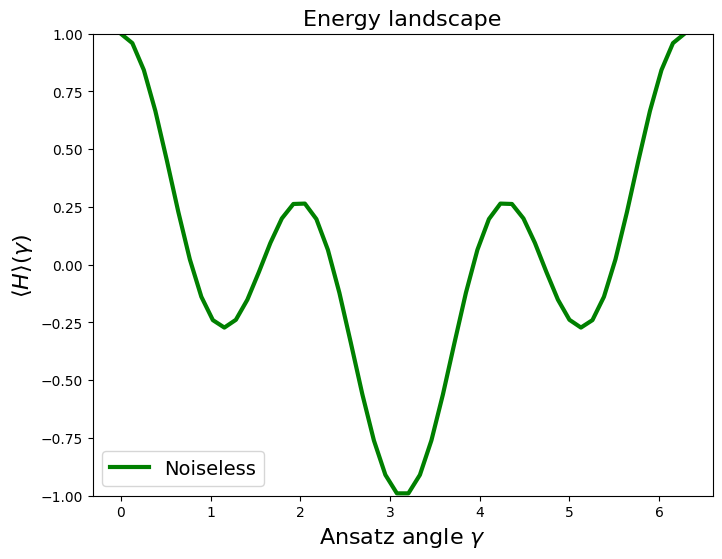

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.title("Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1)
plt.show()

In [7]:
gammas = np.linspace(0, 2 * np.pi, 50)
expectations = [executor_with_noise(variational_circuit(g)) for g in gammas]

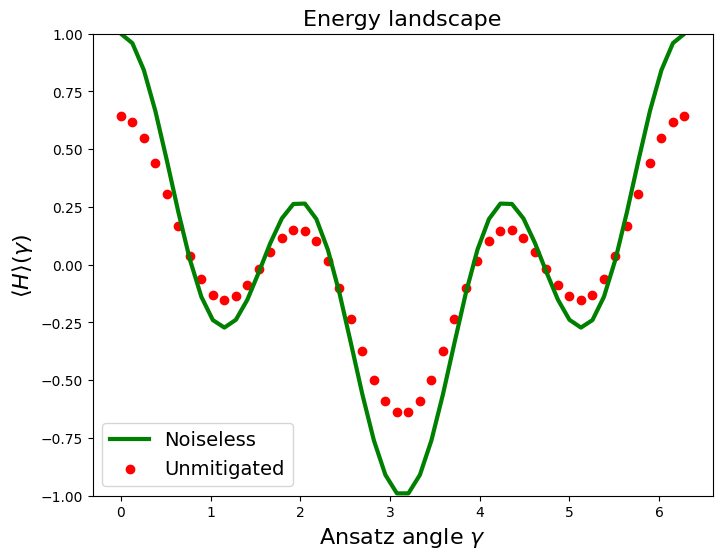

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Ansatz angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);
plt.show()

In [9]:
fac = RichardsonFactory(scale_factors=[1, 3, 5])
mitigated_executor = mitigate_executor(executor_with_noise, factory=fac)

In [10]:
mitigated_expectations = [mitigated_executor(variational_circuit(g)) for g in gammas]

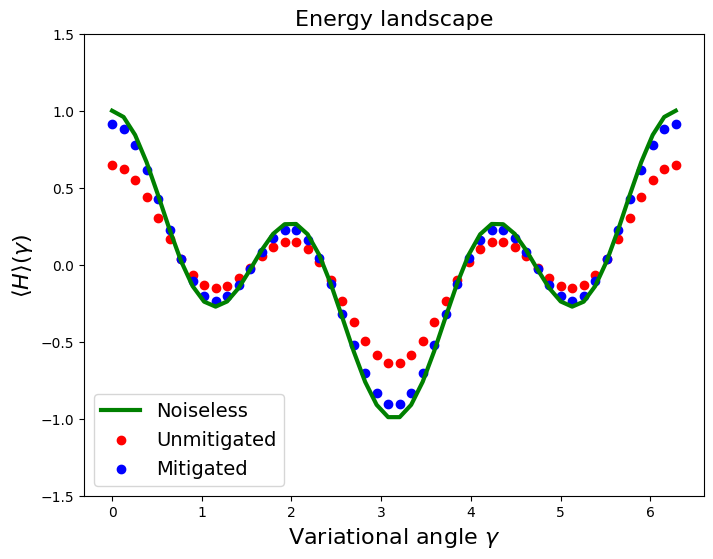

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(gammas, noiseless_expectations, color="g", linewidth=3, label="Noiseless")
plt.scatter(gammas, expectations, color="r", label="Unmitigated")
plt.scatter(gammas, mitigated_expectations, color="b", label="Mitigated")
plt.title(rf"Energy landscape", fontsize=16)
plt.xlabel(r"Variational angle $\gamma$", fontsize=16)
plt.ylabel(r"$\langle H \rangle(\gamma)$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1.5, 1.5);
plt.show()

In [12]:
print(f"Minimum of the noisy landscape: {round(min(expectations), 3)}")
print(f"Minimum of the mitigated landscape: {round(min(mitigated_expectations), 3)}")
print(f"Theoretical ground state energy: {min(np.linalg.eigvals(hamiltonian))}")

Minimum of the noisy landscape: -0.639
Minimum of the mitigated landscape: -0.907
Theoretical ground state energy: -1.0
